In [6]:
from collections import defaultdict
import random
import csv
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import time
import itertools


In [3]:
drive.mount('/content/drive')
dataset = 'drive/My Drive/Colab Notebooks/data/datasetHW3.txt'
datafile1 = pd.read_csv(dataset, delim_whitespace=True, names=['Node1','Node2'])
data1 = datafile1.values.tolist()


Mounted at /content/drive


The Estimation of triangles using a sample size of  2000  is  266332.4694866998
The Estimation of triangles using a sample size of  4000  is  246132.52882782166
The Estimation of triangles using a sample size of  6000  is  169341.66702774505
The Estimation of triangles using a sample size of  8000  is  115788.57654878334
The Estimation of triangles using a sample size of  10000  is  76885.38584971093
The Estimation of triangles using a sample size of  12000  is  55556.04967445098
The Estimation of triangles using a sample size of  14000  is  48558.73972599621


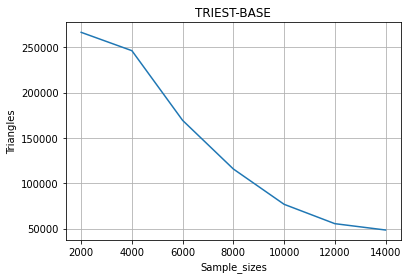

In [7]:
class TriestBase:

  def __init__(self, sample_size):
    self._nbrs = {}
    self._sample_set = set()
    self._sample_size = sample_size
    self._global_counter = 0
    self._local_counter = defaultdict(lambda:0)
    self._num_edges = 0

  def add_function(self, u, v):
    if u in self._nbrs.keys():
      self._nbrs[u].add(v)
    else:
      self._nbrs[u] = set([v])

    if v in self._nbrs.keys():
      self._nbrs[v].add(u)
    else:
      self._nbrs[v] = set([u])

    self._sample_set.add((u,v))
    self._num_edges = self._num_edges + 1



  def delete_function(self, u, v):

    self._nbrs[u].remove(v)
    if len(self._nbrs[u]) == 0:
      del self._nbrs[u]

    self._nbrs[v].remove(u)
    if len(self._nbrs[v]) == 0:
      del self._nbrs[v]    

    self._sample_set.remove((u,v))
    self._num_edges = self._num_edges - 1



  def probability_enter(self, sample_size, timestamp):
    probability_enter = sample_size/timestamp
    random_number = random.uniform(0,1)   
    if random_number < probability_enter :
      return True
    else:
      return False

  def sample_edge(self,u,v,timestamp):
    if timestamp < self._sample_size:
      return True

    else:
      if self.probability_enter(self._sample_size, timestamp):
        # CHANGED
        num_nodes = len(self._sample_set)
        index_to_delete = random.randint(0, len(self._sample_set)-1)
        u_delete, v_delete = list(self._sample_set)[index_to_delete]
        self.delete_function(u_delete,v_delete)
        self.update_counters('rest', u_delete, v_delete)

        return True

    return False


  def update_counters(self, op, u, v):
    if u not in self._nbrs.keys() or v not in self._nbrs.keys():
      return None

    nbrs_u = self._nbrs[u]
    nbrs_v = self._nbrs[v]
    nbrs_intersection = nbrs_u & nbrs_v

    if len(nbrs_intersection) == 0:
      return None
    
    if op == 'sum':
      update_nbrs = 1
      update_counters = len(nbrs_intersection)
    
    elif op == 'rest':
      update_nbrs = -1
      update_counters = -len(nbrs_intersection)

    self._global_counter += update_counters
    self._local_counter[u] += update_counters
    if self._local_counter[u] == 0:
      del self._local_counter[u]
    self._local_counter[v] += update_counters

    if self._local_counter[v] == 0:
      del self._local_counter[v]

    for all_nbrs in nbrs_intersection:
      self._local_counter[all_nbrs] += update_nbrs
      #CHANGE
      if self._local_counter[all_nbrs] == 0:
        del self._local_counter[all_nbrs]


  def run(self,graph):
    timestamp = 0
    for node in graph:
      u = node[0]
      v = node[1]
      # Make it an undirected graph
      if u == v:
        continue
      if u > v:
        change_of_order = (v,u)
        u = change_of_order[0]
        v = change_of_order[1]

      if (u,v) in self._sample_set:
        continue
      
      timestamp += 1

      if self.sample_edge(u,v,timestamp):
        self.add_function(u,v)
        self.update_counters('sum',u,v)


    Estimation_Global_Triangles =self._global_counter * max(1, timestamp*(timestamp-1)*(timestamp-2)/(self._sample_size*(self._sample_size-1)*(self._sample_size-2)))
    print('The Estimation of triangles using a sample size of ' , self._sample_size , ' is ' , Estimation_Global_Triangles)
    return Estimation_Global_Triangles





sample_sizes = [2000, 4000, 6000, 8000, 10000, 12000, 14000]
triangles = []
for sample_size in sample_sizes:
    count = TriestBase(sample_size).run(data1)
    triangles.append(count)

plt.title("TRIEST-BASE")
plt.plot(sample_sizes,triangles)
plt.xlabel("Sample_sizes")
plt.ylabel("Triangles")
plt.xticks(sample_sizes)
plt.grid(True)
plt.show()

    

The Estimation of triangles using a sample size of  2000  is  307550.27323811897
The Estimation of triangles using a sample size of  4000  is  221537.67848474692
The Estimation of triangles using a sample size of  6000  is  164133.2185726526
The Estimation of triangles using a sample size of  8000  is  112115.3951656473
The Estimation of triangles using a sample size of  10000  is  73831.19816521677
The Estimation of triangles using a sample size of  12000  is  55825.84427553787
The Estimation of triangles using a sample size of  14000  is  48474.15007399541


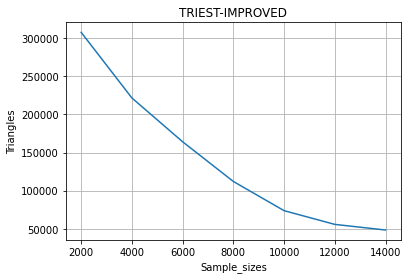

In [8]:
class TriestImproved:

  def __init__(self, sample_size):
    self._nbrs = {}
    self._sample_set = set()
    self._sample_size = sample_size
    self._global_counter = 0
    self._local_counter = defaultdict(lambda:0)
    self._num_edges = 0

  def add_function(self, u, v):
    if u in self._nbrs.keys():
      self._nbrs[u].add(v)
    else:
      self._nbrs[u] = set([v])

    if v in self._nbrs.keys():
      self._nbrs[v].add(u)
    else:
      self._nbrs[v] = set([u])

    self._sample_set.add((u,v))
    self._num_edges = self._num_edges + 1



  def delete_function(self, u, v):

    self._nbrs[u].remove(v)
    if len(self._nbrs[u]) == 0:
      del self._nbrs[u]

    self._nbrs[v].remove(u)
    if len(self._nbrs[v]) == 0:
      del self._nbrs[v]    

    self._sample_set.remove((u,v))
    self._num_edges = self._num_edges - 1



  def probability_enter(self, sample_size, timestamp):
    probability_enter = sample_size/timestamp
    random_number = random.uniform(0,1)   
    if random_number < probability_enter :
      return True
    else:
      return False

  def sample_edge(self,u,v,timestamp):
    if timestamp < self._sample_size:
      return True

    else:
      if self.probability_enter(self._sample_size, timestamp):
        num_nodes = len(self._sample_set)
        index_to_delete = random.randint(0, len(self._sample_set)-1)
        u_delete, v_delete = list(self._sample_set)[index_to_delete]
        self.delete_function(u_delete,v_delete)
        # CHANGE OF TRIEST IMPROVED (no decreasing on the counters despite deleting)
        return True

    return False

  # Now in update_counters we have 1 extra parameter: timestamp to calculate the weight
  def update_counters(self, u, v, timestamp):
    if u not in self._nbrs.keys() or v not in self._nbrs.keys():
      return None

    nbrs_u = self._nbrs[u]
    nbrs_v = self._nbrs[v]
    nbrs_intersection = nbrs_u & nbrs_v

    if len(nbrs_intersection) == 0:
      return None

    weight_update = max(1,((timestamp-1)*(timestamp-2))/(self._sample_size * (self._sample_size-1) ))

    for all_nbrs in nbrs_intersection:
      self._local_counter[all_nbrs] += weight_update
      self._global_counter += weight_update
      self._local_counter[u] += weight_update
      self._local_counter[v] += weight_update



  def run_improved(self,graph):
    timestamp = 0
    for node in graph:
      u = node[0]
      v = node[1]
      # Make it an undirected graph
      if u == v:
        continue
      if u > v:
        change_of_order = (v,u)
        u = change_of_order[0]
        v = change_of_order[1]

      if (u,v) in self._sample_set:
        continue
      
      timestamp += 1

      self.update_counters(u,v, timestamp)
      if self.sample_edge(u,v,timestamp):
        self.add_function(u,v)
        


    Estimation_Global_Triangles =self._global_counter
    print('The Estimation of triangles using a sample size of ' , self._sample_size , ' is ' , Estimation_Global_Triangles)
    return Estimation_Global_Triangles





sample_sizes = [2000, 4000, 6000, 8000, 10000, 12000, 14000]
triangles = []
for sample_size in sample_sizes:
    count = TriestImproved(sample_size).run_improved(data1)
    triangles.append(count)

plt.title("TRIEST-IMPROVED")
plt.plot(sample_sizes,triangles)
plt.xlabel("Sample_sizes")
plt.ylabel("Triangles")
plt.xticks(sample_sizes)
plt.grid(True)
plt.show()

    